# Bike Share Prediction using Neural Network
We build a neural network model to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Dummy Variable
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables.

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for dummy_field in dummy_fields:
    dummy = pd.get_dummies(rides[dummy_field],prefix=dummy_field,drop_first=False)
    rides = pd.concat([rides,dummy], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

In [5]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for feature in quant_features:
    mean, std = data[feature].mean(), data[feature].std()
    scaled_features[feature] = [mean, std]
    data.loc[:, feature] = (data[feature] - mean)/std

In [7]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets
We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Building a Neural Network 

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### self.activation_function is implementing sigmoid function ####
 
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 

            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            X = np.array(X, ndmin=2)
            y = np.array(y, ndmin=2)
            

            ### Forward pass ###

            hidden_inputs = np.dot(X, self.weights_input_to_hidden)# signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer


            # Output layer 
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            

            ### Backward pass ###

            # Output error 
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.

            # output error term
            output_error_term = error

            
            # Hidden layer's contribution to the error
            hidden_error = np.dot( self.weights_hidden_to_output, output_error_term) 

            # Hiddenlayer error term
            
            hidden_error_term = hidden_error.T * hidden_outputs * (1 - hidden_outputs)


            # Weight step (hidden to output)
            delta_weights_h_o += np.dot(hidden_outputs.T ,output_error_term)
            
            # Weight step (input to hidden)
            delta_weights_i_h += np.dot(X.T, hidden_error_term)


        # Updates the weights 
        self.weights_hidden_to_output +=  self.lr * delta_weights_h_o / n_records# update hidden-to-output weights with gradient descent step

        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

        
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs


In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

In [16]:
import sys

def main():
    iterations = 20000
    learning_rate = 0.02
    hidden_nodes = 6
    output_nodes = 1

    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[]}
    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']

        network.train(X, y)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
        sys.stdout.flush()

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
    
    
# plot the losses
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()
    
# Plot the prediction
    fig, ax = plt.subplots(figsize=(8,4))

    mean, std = scaled_features['cnt']
    predictions = network.run(test_features).T*std + mean
    ax.plot(predictions[0], label='Prediction')
    ax.plot((test_targets['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(predictions))
    ax.legend()

    dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45) 
    

Progress: 100.0% ... Training loss: 0.245 ... Validation loss: 0.413

/Users/amit/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


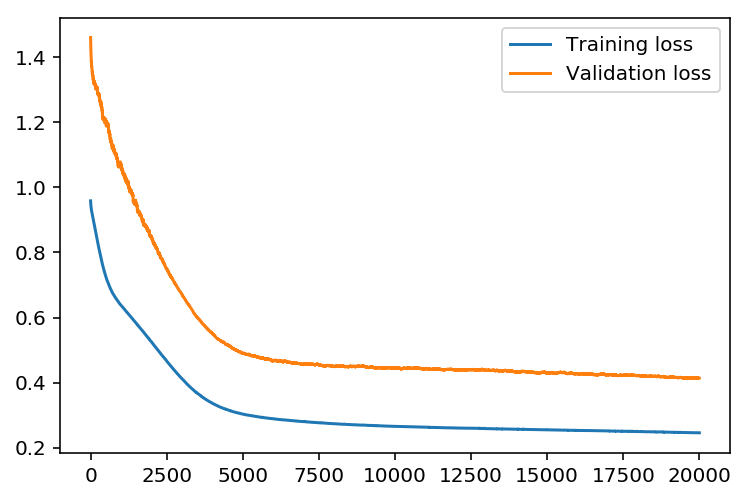

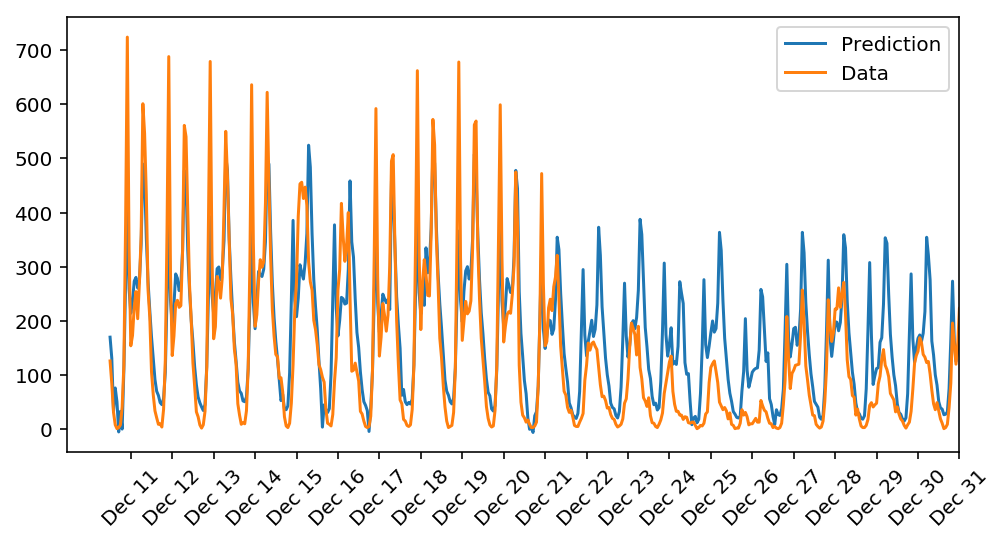

In [17]:
if __name__ == "__main__":
    main()